# Agentic Architecture 2: Tool Use
Without tools LLM is a closed system, limited by the knowledge which was giving to it while training, it cannot get the lets say latest weather, or finincial things, hence this agentic architecture gives the ability to get real time data, and provide better answer.

### Definition
The **Tool Use** architecture equips an LLM-powered agent with the ability to call external functions or APIs (the "tools"). The agent autonomously decides when a user's query cannot be answered by its internal knowledge alone and determines which tool is appropriate to call to find the necessary information.

### High-level Workflow

1.  **Receive Query:** The agent receives a request from the user.
2.  **Decision:** The agent analyzes the query and its available tools. It decides if a tool is needed to answer the question accurately.
3.  **Action:** If a tool is needed, the agent formats a call to that tool (e.g., a specific function with the right arguments).
4.  **Observation:** The system executes the tool call, and the result (the "observation") is returned to the agent.
5.  **Synthesis:** The agent integrates the tool's output into its reasoning process to generate a final, grounded answer for the user.

### When to Use / Applications
*   **Research Assistants:** Answering questions that require up-to-the-minute information by using a web search API.
*   **Enterprise Assistants:** Querying internal company databases to answer questions like "How many new users signed up last week?"
*   **Scientific & Mathematical Tasks:** Using a calculator or a computational engine like WolframAlpha for precise calculations that LLMs often struggle with.

### Strengths & Weaknesses
*   **Strengths:**
    *   **Factual Grounding:** Drastically reduces hallucinations by fetching real, live data.
    *   **Extensibility:** The agent's capabilities can be continuously expanded by simply adding new tools.
*   **Weaknesses:**
    *   **Integration Overhead:** Requires careful "plumbing" to define tools, handle API keys, and manage potential tool failures.
    *   **Tool Trust:** The quality of the agent's answer is dependent on the reliability and accuracy of the tools it uses. The agent must trust that its tools provide correct information.


## Financial Analysis Agent - Tool Use Architecture
================================================

An AI agent that uses three financial tools:
1. yfinance - Historical stock price data
2. stockstats - Technical indicators (RSI, MACD, moving averages)
3. finnhub - Real-time market news and data

Requirements:
    pip install yfinance stockstats finnhub-python
    pip install langchain-groq langgraph rich python-dotenv pandas

Setup:
-    Create a .env file with:
-    OPENAI_API_KEY=your_key_here
-    LANGCHAIN_API_KEY=your_langsmith_key
-    FINNHUB_API_KEY=your_finnhub_key

In [1]:
import os
import json
from typing import List, Annotated, TypedDict, Optional
from dotenv import load_dotenv

# LangChain components
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, ToolMessage
from pydantic import BaseModel, Field

# LangGraph components
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode

# For pretty printing
from rich.console import Console
from rich.markdown import Markdown

# --- API Key and Tracing Setup ---
load_dotenv()

print("Environment variables loaded and tracing is set up.")

Environment variables loaded and tracing is set up.


### Step 1.1: Creating and Testing the Web Search Tool

**What we are going to do:**
We will instantiate the `TavilySearchResults` tool. The most critical part of defining a tool is its **description**. The LLM uses this natural language description to understand what the tool does and when it should be used. A clear, precise description is essential for the agent to make correct decisions. We will then test the tool directly to see what its raw output looks like.

In [2]:
# Initialize the tool. We can set the max number of results to keep the context consize
search_tool = TavilySearchResults(max_results=2)

search_tool.name = "web_search"
search_tool.description = "A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs."

tools = [search_tool]
print(f"Tool '{search_tool.name}' was created with description: '{search_tool.description}")

console = Console()

# Let's test the tool directly to see its output format
print("\n--- Testing the tool directly ---")
test_query = "What was the score of the last Super Bowl?"
test_result = search_tool.invoke({"query": test_query})
console.print(f"[bold green]Query:[/bold green] {test_query}")
console.print("\n[bold green]Result:[/bold green]")
console.print(test_result)

Tool 'web_search' was created with description: 'A tool that can be used to search the internet for up-to-date information on any topic, including news, events, and current affairs.

--- Testing the tool directly ---


Query: What was the score of the last Super Bowl?

Result:

[
    {
        'title': 'Super Bowl Scores Last 10 Years | StatMuse',
        'url': 'https://www.statmuse.com/nfl/ask/super-bowl-scores-last-10-years',
        'content': '| NFC East | W | L | T | PCT |\n ---  --- \n| Eagles | 14 | 3 | 0 | .824 |\n| Commanders | 12 |
5 | 0 | .706 |\n| NFC North | W | L | T | PCT |\n|  |  |  | 0 |  |\n|  | 14 | 3 | 0 | .824 |\n| NFC South | W | L |
T | PCT |\n| Buccaneers | 10 | 7 | 0 |  |\n| Falcons |  | 9 | 0 |  |\n| NFC West | W | L | T | PCT |\n| Rams | 10 |
7 | 0 | .588 |\n|  | 10 | 7 | 0 | .588 | [...] | TEAM | W | L | T | PCT |\n ---  --- \n| Eagles | 14 | 3 | 0 | .824
|\n| Commanders | 12 | 5 | 0 | .706 |\n| Cowboys | 7 | 10 | 0 | .412 |\n| Giants | 3 | 14 | 0 | .176 
|\n\nSchedule\n\n| DATE | MATCHUP |  |  | TIME (ET) |\n ---  --- \n| Thu  9/4 | DAL | @ | PHI | 8:20 PM |\n| Sun  
9/14 | PHI | @ | KC | 4:25 PM |\n| Sun  9/21 | LAR | @ | PHI | 1:00 PM |\n| Sun  9/28 | PHI | @ | TB | 1:00 PM |\n|
Sun  10/5 | DEN | @ | PHI | 1:00 PM |\n\nLast Game \n\nEagles\n\n4 - 0 - 0\n\n40\n\nFinal\n\n22\n\nChiefs\n\n2 - 1 
- 0 [...] Sun, Feb 12, 2023\n\nChiefs\n\nEagles\n\nFinal\n\nSun, Feb 13, 2022\n\nBengals\n\n20\n\nFinal\n\nSun, Feb
7, 2021\n\nChiefs\n\n9\n\nBuccaneers\n\n31\n\nFinal\n\nSun, Feb 2, 
2020\n\n49ers\n\n20\n\nChiefs\n\n31\n\nFinal\n\nSun, Feb 3, 2019\n\nPatriots\n\n13\n\nRams\n\n3\n\nFinal\n\nSun, 
Feb 4, 2018\n\nEagles\n\n41\n\nPatriots\n\n33\n\nFinal\n\nSun, Feb 5, 
2017\n\nPatriots\n\n34\n\nFalcons\n\n28\n\nFinal\n\nSun, Feb 7, 
2016\n\nPanthers\n\n10\n\nBroncos\n\n24\n\nFinal\n\n### Related Searches',
        'score': 0.7045877
    },
    {
        'title': 'List of Super Bowl champions - Wikipedia',
        'url': 'https://en.wikipedia.org/wiki/List_of_Super_Bowl_champions',
        'content': '| XLV | February 6, 2011 (2010) | Green Bay PackersN (5, 4–1) (#endnote_WildCardW) | 31–25 | 
Pittsburgh SteelersA (8, 6–2) | Cowboys Stadium | Arlington, Texas | 103,219 | Walt Anderson "Walt Anderson 
(American football)") |  |\n| XLVI | February 5, 2012 (2011) | New York GiantsN (5, 4–1) | 21–17 | New England 
PatriotsA (7, 3–4) | Lucas Oil Stadium | Indianapolis, Indiana | 68,658 | John Parry "John Parry (American football
official)") |  | [...] | LI | February 5, 2017 (2016) | New England PatriotsA (9, 5–4) | 34–28 
(OT#National_Football_League "Overtime (sports)")) | Atlanta FalconsN (2, 0–2) | NRG Stadium (2) | Houston, Texas 
(3) | 70,807 | Carl Cheffers |  |\n| LII | February 4, 2018 (2017) | Philadelphia EaglesN (3, 1–2) | 41–33 | New 
England PatriotsA (10, 5–5) | U.S. Bank Stadium | Minneapolis, Minnesota (2) | 67,612 | Gene Steratore |  | [...] |
Game | Date (Season) | Winning team | Score | Losing team | Venue | City | Attendance | Referee | Ref. |\n| I  | 
January 15, 1967 (1966 AFL/1966 NFL) | Green Bay Packersn (1, 1–0) | 35–10 | Kansas City Chiefsa (1, 0–1) | Los 
Angeles Memorial Coliseum | Los Angeles, California | 61,946 | Norm Schachter |  |\n| II  | January 14, 1968 (1967 
AFL/1967 NFL) | Green Bay Packersn (2, 2–0) | 33–14 | Oakland Raidersa (1, 0–1) | Miami Orange Bowl | Miami, 
Florida | 75,546 | Jack Vest |  |',
        'score': 0.6578248
    }
]

## Phase 2: Building the Tool-Using Agent with LangGraph
### Step 2.1 : Defining the Graph


In [7]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
print("AgentState TypeDict defined to manage conversation history.")

AgentState TypeDict defined to manage conversation history.


### Binding the Tools to the LLM
We use the `.bind_tools()` which passes the name and description of our tools to the LLM's system prompt. This allows the model's internal logic to decide when to call a tool

In [8]:
llm = ChatGroq(model='llama-3.1-8b-Instant')
llm_with_tools = llm.bind_tools(tools)
print("LLM has been bound witht the providedd tools")

LLM has been bound witht the providedd tools


### Step 2.3: Defining the Agent Nodes

**What we are going to do:**
Our graph will have two main nodes:
1.  **`agent_node`:** This is the "brain". It calls the LLM with the current conversation history. The LLM's response will either be a final answer or a request to call a tool.
2.  **`tool_node`:** This is the "hands". It takes the tool call request from the `agent_node`, executes the corresponding tool, and returns the output. We will use LangGraph's pre-built `ToolNode` for this.

In [9]:
def agent_node(state: AgentState):
    """The primary node that calls the LLM to decide the next action."""
    console.print("--- AGENT: Thinking... ---")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# The ToolNode is a pre-built node from LangGraph that executes tools
tool_node = ToolNode(tools)

print("Agent node and Tool node have been defined.")

Agent node and Tool node have been defined.


In [10]:
def router_function(state: AgentState) -> str:
    """Inspects the agent's last message to decide the next step."""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        # The agent has requested a tool call
        console.print("--- ROUTER: Decision is to call a tool. ---")
        return "call_tool"
    else:
        # The agent has provided a final answer
        console.print("--- ROUTER: Decision is to finish. ---")
        return "__end__"

print("Router function defined.")

Router function defined.


## Phase 3: Assembling and Running the Workflow

Now we'll wire all the components together into a complete, executable graph and run it on a query that forces the agent to use its new web search capability.

In [12]:
graph_builder = StateGraph(AgentState)

# Add the nodes
graph_builder.add_node("agent", agent_node)
graph_builder.add_node("call_tool", tool_node)

# Set the entry point
graph_builder.set_entry_point("agent")

# Add the conditional router
graph_builder.add_conditional_edges(
    "agent",
    router_function,
)

# Add the edge from the tool node back to the agent to complete the loop
graph_builder.add_edge("call_tool", "agent")

# Compile the graph
tool_agent_app = graph_builder.compile()

print("Tool-using agent graph compiled successfully!")



Tool-using agent graph compiled successfully!


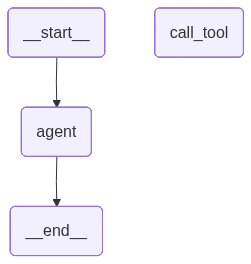

In [14]:
# Another PNG method that sometimes works better
try:
    from IPython.display import Image, display
    
    mermaid_png = tool_agent_app.get_graph().draw_mermaid_png()
    display(Image(mermaid_png))
except Exception as e:
    print(f"Mermaid PNG failed: {e}")

In [15]:
user_query = "What were the main announcements from Apple's latest WWDC event?"
initial_input = {"messages": [("user", user_query)]}

console.print(f"[bold cyan]🚀 Kicking off Tool Use workflow for request:[/bold cyan] '{user_query}'\n")

for chunk in tool_agent_app.stream(initial_input, stream_mode="values"):
    chunk["messages"][-1].pretty_print()
    console.print("\n---\n")

console.print("\n[bold green]✅ Tool Use workflow complete![/bold green]")

🚀 Kicking off Tool Use workflow for request: 'What were the main announcements from Apple's latest WWDC event?'

================================ Human Message =================================

What were the main announcements from Apple's latest WWDC event?


---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to call a tool. ---

================================== Ai Message ==================================
Tool Calls:
  web_search (pfft25nqs)
 Call ID: pfft25nqs
  Args:
    query: Apple WWDC 2023 main announcements


---

================================= Tool Message =================================
Name: web_search

[{"title": "WWDC23 Recap: Key Features, Updates, and New Products", "url": "https://onesignal.com/blog/wwdc23-recap/", "content": "This year’s WWDC conference was especially exciting, as Apple continues to push the envelope with new features and products made possible by their revolutionary Apple Silicon chip. Major headlines include the announcement of a new augmented reality (AR) headset (complete with a new VisionOS), an even skinnier and sleeker 15-inch Macbook Air, a brand new MacOS Sonoma, powerful MacPro and Mac Studios updates enabled by the latest M2 Ultra chip, and exciting iOS17, iPadOS17,  tvOS17, watchOS 10 [...] ## WatchOS 10\n\nAt WWDC23, Apple announced that they'd made comprehensive app redesigns across WatchOS to improve ease of use, functionality, and UX. Those updates include two new watch faces (a \"Palette\" option and Snoopy and Woodstock animations), new ways to na

---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to finish. ---

================================== Ai Message ==================================

The main announcements from Apple's latest WWDC event include:

- A new augmented reality (AR) headset, Apple Vision Pro, with a new VisionOS
- A new 15-inch Macbook Air with a thinner and sleeker design
- A new MacOS Sonoma with improved features and updates
- Powerful MacPro and Mac Studios updates enabled by the latest M2 Ultra chip
- Exciting iOS17, iPadOS17, tvOS17, and watchOS 10 updates, including comprehensive app redesigns, new watch faces, and improved functionality
- An update to AirPods Pro (2nd generation) with powerful new features through a free firmware update, including Adaptive Audio, Personalized Volume, and Conversation Awareness.


---

✅ Tool Use workflow complete!

### Step 4.2: Evaluating with LLM-as-a-Judge

**What we are going to do:**
We will create a 'Judge' LLM to provide a structured, quantitative evaluation of the agent's performance. The evaluation criteria will be tailored specifically to assess the quality of tool use.

In [16]:
class ToolUseEvaluation(BaseModel):
    """Schema for evaluating the agent's tool use and final answer."""
    tool_selection_score: int = Field(description="Score 1-5 on whether the agent chose the correct tool for the task.")
    tool_input_score: int = Field(description="Score 1-5 on how well-formed and relevant the input to the tool was.")
    synthesis_quality_score: int = Field(description="Score 1-5 on how well the agent integrated the tool's output into its final answer.")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(ToolUseEvaluation)

# To evaluate, we need to reconstruct the full conversation trace
final_answer = tool_agent_app.invoke(initial_input)
conversation_trace = "\n".join([f"{m.type}: {m.content or ''} {getattr(m, 'tool_calls', '')}" for m in final_answer['messages']])

def evaluate_tool_use(trace: str):
    prompt = f"""You are an expert judge of AI agents. Evaluate the following conversation trace based on the agent's tool use on a scale of 1-5. Provide a brief justification.
    
    Conversation Trace:
    ```
    {trace}
    ```
    """
    return judge_llm.invoke(prompt)

console.print("--- Evaluating Tool Use Performance ---")
evaluation = evaluate_tool_use(conversation_trace)
console.print(evaluation.model_dump())

--- AGENT: Thinking... ---

--- ROUTER: Decision is to call a tool. ---

--- AGENT: Thinking... ---

--- ROUTER: Decision is to finish. ---

--- Evaluating Tool Use Performance ---

{
    'tool_selection_score': 5,
    'tool_input_score': 5,
    'synthesis_quality_score': 4,
    'justification': "The AI agent used the web_search tool to retrieve relevant information from the web. The tool
output was well-integrated into the final answer, which provided a comprehensive summary of the main announcements 
from Apple's WWDC event. However, the AI agent could have provided more details from the tool output, such as the 
specific features of the new MacOS Sonoma and the updates to AirPods Pro. The tool selection was appropriate, as 
the web_search tool is suitable for retrieving general information from the web. The input to the tool was 
well-formed and relevant, as it contained the specific query related to Apple's WWDC event. Synthesis quality 
score: 4, Tool input score: 5, Tool selection score: 5}"
}

## Conclusion

In this notebook, we have built a complete, functioning agent based on the **Tool Use** architecture. We successfully equipped a Nebius-powered LLM with a web search tool and used LangGraph to create a robust reasoning loop that allows the agent to decide when and how to use it.

The end-to-end execution and subsequent evaluation demonstrate the immense value of this pattern. By connecting our agent to live, external information, we have fundamentally overcome the limitation of static training data. The agent is no longer just a reasoner; it is a researcher, capable of providing answers that are grounded, factual, and current. This architecture is a foundational building block for creating virtually any practical, real-world AI assistant.